In [1]:
### python train_wrn_ebm.py --lr .0001 --dataset cifar10 
### --optimizer adam 
### --p_x_weight 1.0 --p_y_given_x_weight 1.0 
### --p_x_y_weight 0.0 --sigma .03 --width 10 --depth 28 
### --save_dir /YOUR/SAVE/DIR --plot_uncond --warmup_iters 1000

## library 선언

In [24]:
import utils
import torch as t, torch.nn as nn, torch.nn.functional as tnnF, torch.distributions as tdist
from torch.utils.data import DataLoader, Dataset
import torchvision as tv, torchvision.transforms as tr
import os
import sys
import argparse
#import ipdb
import numpy as np
import json
# Sampling
from tqdm import tqdm
t.backends.cudnn.benchmark = True
t.backends.cudnn.enabled = True
seed = 1
im_sz = 32
n_ch = 3

## Dataset 선언

In [25]:
class DataSubset(Dataset):
    def __init__(self, base_dataset, inds=None, size=-1):
        self.base_dataset = base_dataset
        self.inds = inds

    def __getitem__(self, index):
        base_ind = self.inds[index]
        return self.base_dataset[base_ind]

    def __len__(self):
        return len(self.inds)

In [26]:
def get_data():
    transform_train = tr.Compose(
        [tr.Pad(4, padding_mode="reflect"),
         tr.RandomCrop(im_sz),
         tr.RandomHorizontalFlip(),
         tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + 3e-2 * t.randn_like(x)]
    )
    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + 3e-2 * t.randn_like(x)]
    )
    def dataset_fn(train, transform):
        return tv.datasets.CIFAR10(root='/data2/mawjdgus', transform=transform, download=False, train=train)

    # get all training inds
    full_train = dataset_fn(True, transform_train)
    all_inds = list(range(len(full_train)))
    
    # set seed
    np.random.seed(1234)
    
    # shuffle
    np.random.shuffle(all_inds)
    
    # seperate out validation set
    valid_inds, train_inds = all_inds[:5000], all_inds[5000:]
    
    train_inds = np.array(train_inds)
    train_labeled_inds = []
    other_inds = []
    train_labels = np.array([full_train[ind][1] for ind in train_inds])
    
    train_labeled_inds = train_inds

    dset_train = DataSubset(
        dataset_fn(True, transform_train),
        inds=train_inds)
    dset_train_labeled = DataSubset(
        dataset_fn(True, transform_train),
        inds=train_labeled_inds)
    dset_valid = DataSubset(
        dataset_fn(True, transform_test),
        inds=valid_inds)
    dload_train = DataLoader(dset_train, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
    dload_train_labeled = DataLoader(dset_train_labeled, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
    dload_train_labeled = cycle(dload_train_labeled)
    dset_test = dataset_fn(False, transform_test)
    dload_valid = DataLoader(dset_valid, batch_size=64, shuffle=False, num_workers=4, drop_last=False)
    dload_test = DataLoader(dset_test, batch_size=64, shuffle=False, num_workers=4, drop_last=False)
    return dload_train, dload_train_labeled, dload_valid,dload_test

In [27]:
def cycle(loader):
    while True:
        for data in loader:
            yield data

## Buffer

In [28]:
def init_random(bs):
    return t.FloatTensor(bs, n_ch, im_sz, im_sz).uniform_(-1, 1)

In [29]:
dload_train, dload_train_labeled, dload_valid, dload_test = get_data()

In [30]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

## Sampling

In [31]:
def get_sample_q(device):
    def sample_p_0(replay_buffer, bs, y=None):
        buffer_size = len(replay_buffer) // 10
        inds = t.randint(0, buffer_size, (bs,))
        
        # if cond, convert inds to class conditional inds
        if y is not None:
            inds = y.cpu() * buffer_size + inds
            assert not args.uncond, "Can't drawn conditional samples without giving me y"
        buffer_samples = replay_buffer[inds]
        random_samples = init_random(bs)
        choose_random = (t.rand(bs) < .05).float()[:, None, None, None] 
        samples = choose_random * random_samples + (1 - choose_random) * buffer_samples
        return samples.to(device), inds

    def sample_q(f, replay_buffer, y=None, n_steps=20):
        """this func takes in replay_buffer now so we have the option to sample from
        scratch (i.e. replay_buffer==[]).  See test_wrn_ebm.py for example.
        """
        f.eval()
        # get batch size
        bs = 64 if y is None else y.size(0) 
        # generate initial samples and buffer inds of those samples (if buffer is used)
        init_sample, buffer_inds = sample_p_0(replay_buffer, bs=bs, y=y)
        x_k = t.autograd.Variable(init_sample, requires_grad=True)
        # sgld
        for k in range(n_steps): # 20번 ?
            f_prime = t.autograd.grad(f(x_k, y=y).sum(), [x_k], retain_graph=True)[0]
            x_k.data += 1 * f_prime + 1e-2 * t.randn_like(x_k)
        f.train()
        final_samples = x_k.detach()
        # update replay buffer
        if len(replay_buffer) > 0:
            replay_buffer[buffer_inds] = final_samples.cpu()
        return final_samples
    return sample_q

In [32]:
sample_q = get_sample_q(device)

## 모델, replay_buffer 불러오기

In [33]:
import wideresnet

In [34]:
class F(nn.Module): # unconditioned
    def __init__(self, depth=28, width=2, norm=None, dropout_rate=0.0, n_classes=10):
        super(F, self).__init__()
        self.f = wideresnet.Wide_ResNet(depth, width, norm=norm, dropout_rate=dropout_rate) # wideresnet f (function)
        self.energy_output = nn.Linear(self.f.last_dim, 1) # energy output, scalar
        self.class_output = nn.Linear(self.f.last_dim, n_classes) # class output, logits

    def forward(self, x, y=None):
        penult_z = self.f(x) # 
        return self.energy_output(penult_z).squeeze() # energy output, scalar

    def classify(self, x):
        penult_z = self.f(x)
        return self.class_output(penult_z).squeeze() # class output, logits

In [35]:
class CCF(F): # conditioned
    def __init__(self, depth=28, width=2, norm=None, dropout_rate=0.0, n_classes=10):
        super(CCF, self).__init__(depth, width, norm=norm, dropout_rate=dropout_rate, n_classes=n_classes)

    def forward(self, x, y=None):
        logits = self.classify(x)
        if y is None:
            return logits.logsumexp(1)
        else:
            return t.gather(logits, 1, y[:, None])

In [36]:
def get_model_and_buffer(device, sample_q):
    model_cls = CCF
    f = model_cls(28, 10, None, dropout_rate=0.0, n_classes=10)
    assert 10000 % 10 == 0, "Buffer size must be divisible by args.n_classes"
    replay_buffer = init_random(10000) # [10000,3,32,32]
    f = f.to(device)
    return f, replay_buffer

In [37]:
f, replay_buffer = get_model_and_buffer(device, sample_q)

| Wide-Resnet 28x10


In [38]:
sqrt = lambda x: int(t.sqrt(t.Tensor([x])))

## Optimizer

In [39]:
params = f.parameters()
optim = t.optim.Adam(params, lr=1e-4, betas=[.9, .999], weight_decay=0.0)

In [40]:
best_valid_acc = 0.0
cur_iter = 0

## sample q

In [43]:
for epoch in range(200):
    if epoch in [160, 180]:
        for param_group in optim.param_groups:
            new_lr = param_group['lr'] * .3
            param_group['lr'] = new_lr
        print("Decaying lr to {}".format(new_lr))
    for i, (x_p_d, _) in tqdm(enumerate(dload_train)):
        x_p_d = x_p_d.to(device)
        x_lab, y_lab = dload_train_labeled.__next__()
        x_lab, y_lab = x_lab.to(device), y_lab.to(device)
        
        L = 0.
        ## sampling and SGLD
        x_q = sample_q(f, replay_buffer)
        
        ## LogSumExp
        fp_all = f(x_p_d)
        fq_all = f(x_q)
        
        ## 
        fp = fp_all.mean()
        fq = fq_all.mean()
        
        l_p_x = -(fp - fq)
        L += 1.0 * l_p_x
        
        logits = f.classify(x_lab)
        l_p_y_given_x = nn.CrossEntropyLoss()(logits, y_lab)

        if L.abs().item() > 1e8:
            print("BAD BOIIIIIIIIII")
            1/0
            
        optim.zero_grad()
        L.backward()
        optim.step()
        cur_iter += 1
        print(f'iteration : {i}')
        
    print(f'{epoch}:200')

1it [00:00,  1.04it/s]

iteration : 0


2it [00:01,  1.09it/s]

iteration : 1


RuntimeError: DataLoader worker (pid(s) 3117384, 3117640, 3117896, 3118152) exited unexpectedly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


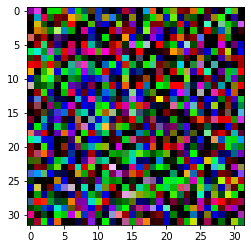

In [42]:
import matplotlib.pyplot as plt
plt.imshow(x_q[2].permute(1,2,0).cpu()) ## 0 epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


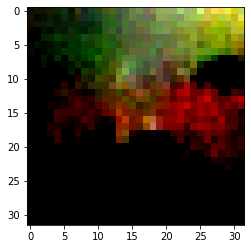

In [22]:
import matplotlib.pyplot as plt
plt.imshow(x_q[2].permute(1,2,0).cpu()) ## 1 epoch

1. Sample $y\sim p(y)$ then sample $\mathbf{x}\sim p_\theta(\mathbf{x}|y)$ via SGLD with energy $E(\mathbf{x}|y)=-f_\theta(\mathbf{x})[y]$ then throw away $y$.
2. Sample $\mathbf{x}~p_\theta(\mathbf{x})$ via SGLD with energy $E(x)=-\text{LogSumExp}_y f_\theta(\mathbf{x})[y]$.

$$\mathbf{x}_0\sim p_0(\mathbf{x}),\\ \mathbf{x}_{i+1}=\mathbf{x}_i-{\alpha\over{2}}{\partial E_\theta(\mathbf{x}_i)\over{\partial\mathbf{x}_i}}+\epsilon,\\\epsilon\sim\mathcal{N}(0,\alpha)$$


원래는 replay_buffer에서 샘플을 $1-\rho$(reinitialization frequency $rho$) 확률로 뽑고, 나머지는 유니폼에서 뽑음으로써 SGLD를 초기화 해준다. 맨 처음의 replay_buffer는 init_random으로 만들어진 $\hat{\mathbf{x}}_0\sim \mathcal{U}(-1,1)$ 이다. -> Initialize SGLD

그리고 나서 SGLD를 진행하는데,
지정된 반복 수만큼, 

$$\hat{\mathbf{x}}_t=\hat{\mathbf{x}}_{t-1}+\alpha\cdot {\partial\text{LogSumExp}_{y^\prime}(f_\theta(\hat{\mathbf{x}}_{t-1})[y^\prime])\over{\partial\hat{\mathbf{x}}_{t-1}}} + \sigma\cdot\mathcal{N}(0,I)$$를 진행해준다

$${\partial\log{p_\theta(\mathbf{x})}\over{\partial\theta}}=\mathbb{E}_{p_\theta(\mathbf{x}^\prime)}[{\partial E_\theta(\mathbf{x}^\prime)\over{\partial\theta}}]-{\partial E_\theta(\mathbf{x})\over{\partial\theta}}$$

이렇게 $\theta$를 업데이트 하는 것은, $p_\theta(\mathbf{x})$로 부터 샘플링된 에너지에 대해서 pulling up 하는 것이고, $p$로부터 샘플링된 energy에 대해서는 pushing down하는 것이다.

$$L_{\text{gen}}(\theta)=\text{LogSumExp}_{y^\prime}(f(\mathbf{x})[y^\prime])-\text{LogSumExp}_{y^\prime}(f(\hat{\mathbf{x}}_t)[y^\prime])$$


---

```
def get_sample_q(device):
    def sample_p_0(replay_buffer, bs, y=None):
        buffer_size = len(replay_buffer) // 10
        inds = t.randint(0, buffer_size, (bs,))
        
        # if cond, convert inds to class conditional inds
        if y is not None:
            inds = y.cpu() * buffer_size + inds
            assert not args.uncond, "Can't drawn conditional samples without giving me y"
        buffer_samples = replay_buffer[inds]
        random_samples = init_random(bs)
        choose_random = (t.rand(bs) < .05).float()[:, None, None, None] 
        samples = choose_random * random_samples + (1 - choose_random) * buffer_samples
        return samples.to(device), inds

    def sample_q(f, replay_buffer, y=None, n_steps=20):
        """this func takes in replay_buffer now so we have the option to sample from
        scratch (i.e. replay_buffer==[]).  See test_wrn_ebm.py for example.
        """
        f.eval()
        # get batch size
        bs = 64 if y is None else y.size(0) 
        # generate initial samples and buffer inds of those samples (if buffer is used)
        init_sample, buffer_inds = sample_p_0(replay_buffer, bs=bs, y=y)
        x_k = t.autograd.Variable(init_sample, requires_grad=True)
        # sgld
        for k in range(n_steps): # 20번
            f_prime = t.autograd.grad(f(x_k, y=y).sum(), [x_k], retain_graph=True)[0]
            x_k.data += 1 * f_prime + 1e-2 * t.randn_like(x_k)
        f.train()
        final_samples = x_k.detach()
        # update replay buffer
        if len(replay_buffer) > 0:
            replay_buffer[buffer_inds] = final_samples.cpu()
        return final_samples
    return sample_q
```



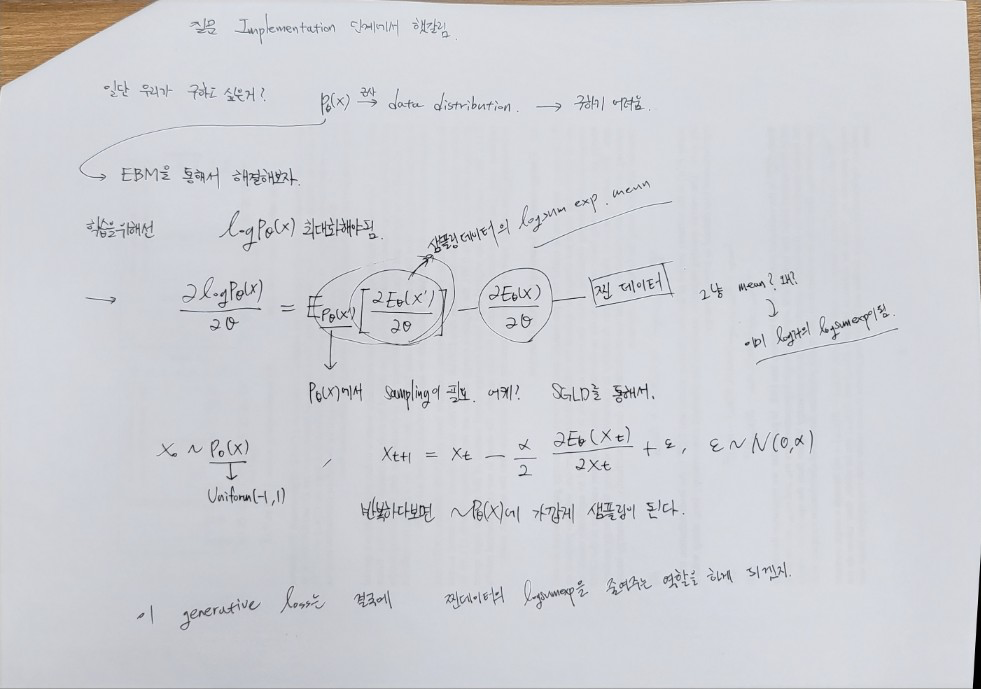

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


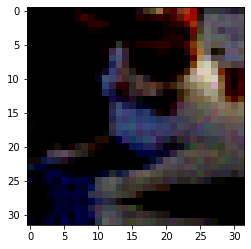

In [72]:
plt.imshow(x_p_d[1].permute(1,2,0).cpu())